In [1]:
import torch
import torch.nn as nn
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast, DistilBertModel
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
import time, datetime, random, re
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW
from tqdm.notebook import tqdm

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from operator import itemgetter
from tqdm.notebook import tqdm

import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

SEED = 15
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.cuda.amp.autocast(enabled=True)
device = torch.device("cuda")

2023-05-16 06:49:07.265161: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 06:49:07.782657: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Tokens prep

In [2]:
with open('./data/papers_merged.pickle', 'rb') as f:
    fetched_data = pickle.load(f)

physics = {'quant-ph', 'physics', 'nucl-th', 'nucl-ex', 'nlin', 
           'math-ph', 'hep-th', 'hep-ph', 'hep-lat', 'hep-ex', 
           'gr-qc', 'cond-mat', 'astro-ph', 'adap-org', 'physics'}

tags_names = {
    'cs': 'Computer Science',
    'econ': 'Economics',
    'eess': 'Electrical Engineering and Systems Science',
    'math': 'Mathematics',
    'physics': 'Physics',
    'q-bio': 'Quantitative Biology',
    'q-fin': 'Quantitative Finance',
    'stat': 'Statistics',
}

def get_cat(tag):
    # returns tag category as number / -1 if unkown
    tag = tag.split('.')[0]
    if tag in physics:
        return "physics"
    return tag

def remove_mul_spaces(text):
    return re.sub(r"\s+", " ", text)

data = pd.DataFrame([{'title': remove_mul_spaces(paper['title']),
                      'summary': remove_mul_spaces(paper['summary']),
                      'category': get_cat(paper['arxiv_primary_category']['term'])} for paper in fetched_data])

cat = pd.Categorical(data.category)
data = data\
    .drop(columns=['category'])\
    .assign(category=cat.codes)

In [3]:
 cat.categories

Index(['cs', 'econ', 'eess', 'math', 'physics', 'q-bio', 'q-fin', 'stat'], dtype='object')

In [6]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

goal_num = 7_000
num_samples = {cat : min(num, goal_num) for cat, num in data.category.value_counts().reset_index().values}
data_undersamp, _ = RandomUnderSampler(sampling_strategy=num_samples)\
    .fit_resample(data, data.category)
train_data, val_data = train_test_split(data_undersamp, test_size=.1, stratify=data_undersamp.category)

shuffled = np.arange(len(train_data))
np.random.shuffle(shuffled)
train_data = train_data.iloc[shuffled]

MAX_LENGTH_TITLE = 30
MAX_LENGTH_SUMM = 290

def batch_encode(tokenizer, df, return_tensors='pt', batch_size=256):
    # return list of batches (input_ids, attention_mask) and list of batches of y
    title, summ = df.title.to_list(), df.summary.to_list()
    total = df.title.str.cat([pd.Series(tokenizer.sep_token, index=df.index), df.summary]).to_list()
    y = df.category.values
    
    encoded = []
    ys = []
    getter = itemgetter('input_ids', 'attention_mask')
    
    for i in tqdm(range(0, len(title), batch_size)):
        slice_ = slice(i, i + batch_size)
        batch_t = title[slice_]
        batch_s = summ[slice_]
        
        inputs = []
        for batch, max_length  in [(batch_t, MAX_LENGTH_TITLE), (batch_s, MAX_LENGTH_SUMM)]:
            inputs.extend(getter(tokenizer.batch_encode_plus(
                batch,
                max_length=max_length,
                padding='longest',
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=False,
                return_tensors=return_tensors
            )))
        
        encoded.append(inputs)
        ys.append(torch.tensor(y[slice_]).to(int))
    
    return encoded, ys

In [16]:
pd.core.strings.accessor.StringMethods.cat?

Signature:
pd.core.strings.accessor.StringMethods.cat(
    self,
    others=None,
    sep=None,
    na_rep=None,
    join: 'AlignJoin' = 'left',
) -> 'str | Series | Index'
Docstring:
Concatenate strings in the Series/Index with given separator.

If `others` is specified, this function concatenates the Series/Index
and elements of `others` element-wise.
If `others` is not passed, then all values in the Series/Index are
concatenated into a single string with a given `sep`.

Parameters
----------
others : Series, Index, DataFrame, np.ndarray or list-like
    Series, Index, DataFrame, np.ndarray (one- or two-dimensional) and
    other list-likes of strings must have the same length as the
    calling Series/Index, with the exception of indexed objects (i.e.
    Series/Index/DataFrame) if `join` is not None.

    If others is a list-like that contains a combination of Series,
    Index or np.ndarray (1-dim), then all elements will be unpacked and
    must satisfy the above criteria individ

In [20]:
pd.Series("-fdsja", index=train_data.index)

3793     -fdsja
9554     -fdsja
44394    -fdsja
22658    -fdsja
28601    -fdsja
          ...  
26859    -fdsja
5228     -fdsja
10565    -fdsja
43621    -fdsja
27338    -fdsja
Length: 45000, dtype: object

3793     Deep learning prediction of patient response t...
9554     On monitoring development indicators using hig...
44394    A Practitioner's Guide to Bayesian Inference i...
22658    Optimal radio labelings of the Cartesian produ...
28601    Exciton Superfluidity in 2D Heterostructures f...
Name: title, dtype: object

In [20]:
# train_seq, val_seq = (batch_encode(tokenizer, df, batch_size=32) for df in [train_data, val_data])

In [21]:
# import pickle

# with open('./data/encoded.pickle', 'wb+') as f:
#     pickle.dump({'train': train_seq, 'val': val_seq}, f)

In [22]:
with open('./data/encoded.pickle', 'rb') as f:
    pickle_obj = pickle.load(f)
train_seq, val_seq = pickle_obj['train'], pickle_obj['val']

In [23]:
from pathlib import Path

class MyModel(nn.Module):
    def __init__(self, path=None, n_labels=8):
        super().__init__()
        self.transformer = None
        if path is None:
            self.transformer = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.title_lin = nn.Sequential(
            nn.Linear(in_features=768, out_features=1024),
            nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=1024),
            nn.Dropout(.2),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
        )
        self.summ_lin = nn.Sequential(
            nn.Linear(in_features=768, out_features=1024),
            nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=1024),
            nn.Dropout(.2),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
        )
        
        self.title_clf = nn.Linear(in_features=512, out_features=n_labels)
        self.summ_clf = nn.Linear(in_features=512, out_features=n_labels)
        
        self.total_clf = nn.Sequential(
            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=1024),
            nn.Dropout(.2),
            nn.Linear(in_features=1024, out_features=n_labels),
        )
        
        if path is not None:
            self.load(path)
    
    def forward(self, input_ids_title, attention_mask_title, input_ids_sum, attention_mask_sum):
        X_title = self.transformer(input_ids=input_ids_title, attention_mask=attention_mask_title)[0][:, 0]
        X_sum = self.transformer(input_ids=input_ids_sum, attention_mask=attention_mask_sum)[0][:, 0]
        X_title = self.title_lin(X_title)
        X_sum = self.summ_lin(X_sum)
        X = torch.concat((X_title, X_sum), dim=-1)
        title_pred = self.title_clf(X_title)
        sum_pred = self.summ_clf(X_sum)
        total_pred = self.total_clf(X)
        return title_pred ,sum_pred ,total_pred
    
    def save(self, path):
        path = Path(path)
        if not path.exists():
            path.mkdir()
        for i, layer in enumerate([self.title_lin, self.summ_lin, self.title_clf, self.summ_clf, self.total_clf]):
            torch.save(layer.state_dict(), path / f"layer_{i}.pt")
        self.transformer.save_pretrained(path / "transformer-chkp")
        
    def load(self, path):
        path = Path(path)
        self.transformer = DistilBertModel.from_pretrained(
            path / "transformer-chkp",
            local_files_only=True
        )
        for i, layer in enumerate([self.title_lin, self.summ_lin, self.title_clf, self.summ_clf, self.total_clf]):
            layer.load_state_dict(torch.load(path / f"layer_{i}.pt"))

In [24]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
from random import shuffle
from collections import defaultdict

class MyDataset(Dataset):
    def __init__(self, seq, epoch_size=None):
        super().__init__()
        self.X, self.y = seq
        self.epoch_size = epoch_size or len(self.X)

    def __len__(self):
        return self.epoch_size

    def __getitem__(self, idx):
        if idx >= self.epoch_size:
            raise IndexError
        return self.X[idx], self.y[idx]
    
    def reshuffle(self):
        zipped = list(zip(self.X, self.y))
        shuffle(zipped)
        self.X, self.y = zip(*zipped)

def get_prediction(logits_on_gpu):
    return logits_on_gpu.argmax(axis=1).flatten().detach().cpu().numpy()

def get_topp(logits_on_gpu, p):
    proba, inds = logits_on_gpu.softmax(dim=-1).detach().cpu().to(float).topk(2)
    return list(zip(inds, proba))
    # vals, inds = logits_on_gpu.softmax(dim=-1).detach().cpu().to(float).sort()
    # ret = []
    # for val, ind in zip(vals, inds):
    #     mask = ~(val.cumsum(dim=-1) < (1 - p))
    #     ret.append([ind[mask].flip(dims=[-1])[:3], val[mask].flip(dims=[-1])[:3]])
    # return ret

def topp_accuracy(topp, y_true_cpu):
    return sum([label_true in labels_pred 
                for (labels_pred, _), label_true in zip(topp, y_true_cpu)])\
            / len(y_true_cpu)

def train(model, dataloader, optimizer, scaler, loss_fn, scheduler, exp_mean_alpha = .8):
    # the greater exp_mean_alpha, the lesser influence of new means
    metrics = defaultdict(float)

    model.train()
    
    dataloader.reshuffle()
    pbar = tqdm(dataloader)
    cur_acc = None
    
    for X, y_true in pbar:
        X = [x.to(device) for x in X]
        y_true_cpu = y_true
        y_true = y_true.to(device)
        
        optimizer.zero_grad()
        with autocast():
            title_logits, sum_logits, pred_logits = model(*X)
        
        losses = []
        for name, logits in [('title', title_logits), ('sum', sum_logits), ('total', pred_logits)]:
            loss = loss_fn(logits, y_true)
            losses.append(loss)
            metrics[f'loss_{name}'] += loss.item()
            with torch.no_grad():
                y_pred = get_prediction(logits)
                if name == 'total':
                    acc_score = accuracy_score(y_pred, y_true_cpu)
                metrics[f'accuracy_{name}'] += accuracy_score(y_pred, y_true_cpu)

        
        scaler.scale(sum(losses)).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        
        if cur_acc is None:
            cur_acc = acc_score
        else:
            cur_acc = cur_acc * exp_mean_alpha + acc_score * (1 - exp_mean_alpha)
            
        pbar.set_description(f"Accuracy: {cur_acc:.4f}")
        

    for metric in metrics:
        metrics[metric] /= len(dataloader)
    
    torch.cuda.empty_cache()
    
    return metrics

def validate(model, dataloader, loss_fn, **kwargs):
    model.eval()

    metrics = defaultdict(float)
    
    for X, y_true in tqdm(dataloader):
        X = [x.to(device) for x in X]
        y_true_cpu = y_true
        y_true = y_true.to(device)
                                        
                                        
        with torch.no_grad():
            title_logits, sum_logits, pred_logits = model(*X)
            for name, logits in [('title', title_logits), ('sum', sum_logits), ('total', pred_logits)]:
                loss = loss_fn(logits, y_true)
                metrics[f'loss_{name}'] += loss.item()
                with torch.no_grad():
                    y_pred = get_prediction(logits)
                    metrics[f'accuracy_{name}'] += accuracy_score(y_pred, y_true_cpu)

    for metric in metrics:
        metrics[metric] /= len(dataloader)

    torch.cuda.empty_cache()
    return metrics

In [25]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

def plot(acc_history, metrics, path=None):
    if len(acc_history['train']) > 1:
        f, axes = plt.subplots(1, len(metrics))
        f.set_size_inches(15, 5)
        
        for ax, metric in zip(axes, metrics):
            acc_history = {stage : pd.DataFrame(df) for stage, df in acc_history.items()}
            df = pd.concat(pd.DataFrame({'value': df[metric], 'epoch': list(df.index + 1), 'stage': stage})
                           for stage, df in acc_history.items())
            sns.lineplot(data=df, x='epoch', y='value', hue='stage', ax=ax)
            ax.set_xlabel('epoch')
            ax.set_title(metric)
            
        if path is not None:
            plt.savefig(path)
        plt.show()
    else:
        print(acc_history)
        

In [26]:
samples_per_epoch = 400
epochs = 20
train_set = MyDataset(train_seq, samples_per_epoch)
val_set = MyDataset(val_seq)
model = MyModel()
loss_fn = torch.nn.CrossEntropyLoss()
model.cuda()

optimizer = AdamW(model.parameters(),
                  lr=2e-6,
                  weight_decay=0.65
                )

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_set) * epochs)

acc_history = {'train': [], 'val': []}
params = dict(
    optimizer=optimizer,
    scaler=GradScaler(),
    scheduler=scheduler,
    loss_fn=loss_fn,
    exp_mean_alpha=0.95
)
max_acc = 0.

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
tokenizer.encode_plus(tokenizer.sep_token)

{'input_ids': [101, 102, 102], 'attention_mask': [1, 1, 1]}

In [31]:
tokenizer.encode_plus("Hi, I'm steve" + tokenizer.sep_token + "No, he's not")

{'input_ids': [101, 7632, 1010, 1045, 1005, 1049, 3889, 102, 2053, 1010, 2002, 1005, 1055, 2025, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

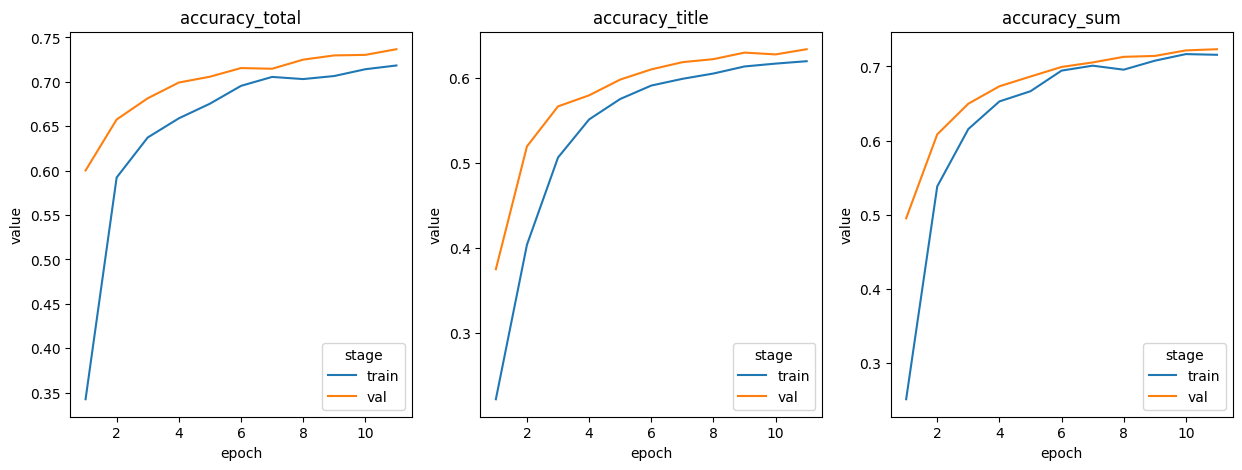

  0%|          | 0/400 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [27]:
for _ in range(epochs):
    clear_output(True)
    plot(acc_history, ["accuracy_total", "accuracy_title", "accuracy_sum"], f"plots/model_6.png")

    acc_history['train'].append(train(model, train_set, **params))
    acc_history['val'].append(validate(model, val_set, **params))
    if acc_history['val'][-1]['accuracy_total'] > max_acc:
        max_acc = acc_history['val'][-1]['accuracy_total']
        model.save(f'models/06')

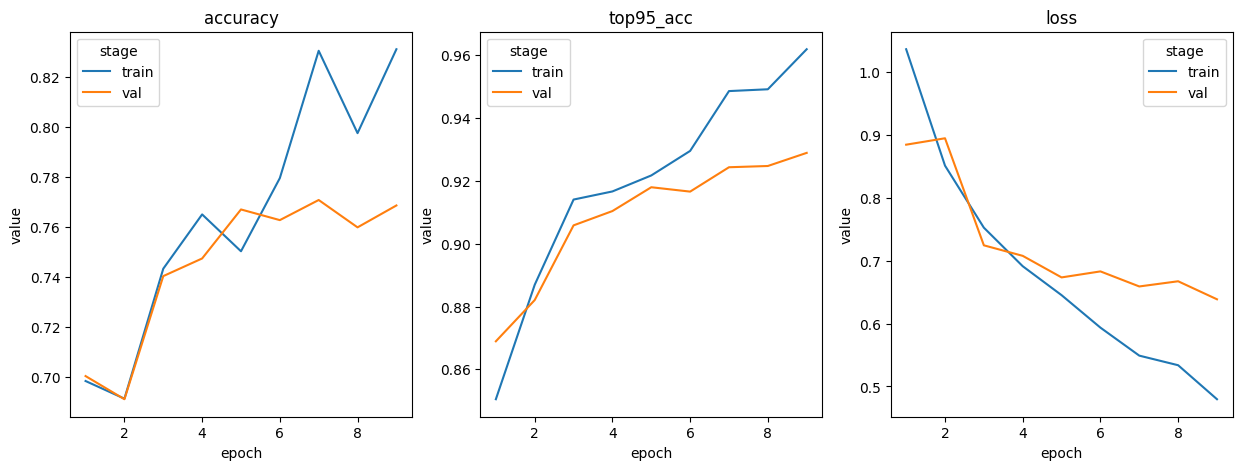

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [22]:
samples_per_epoch = 200
epochs = 10
train_set = MyDataset(train_seq, samples_per_epoch)
val_set = MyDataset(val_seq)

history = {}
for i, lr in enumerate(np.logspace(-7, -4, 6)):
    if i == 0:
        continue
    loss_fn = torch.nn.CrossEntropyLoss()
    model.load("models/04_base")
    model.cuda()

    optimizer = AdamW(model.parameters(),
                      lr=lr,
                      weight_decay=0.65
                    )

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=len(train_set) * epochs)
    
    acc_history = {'train': [], 'val': []}
    params = dict(
        optimizer=optimizer,
        scaler=GradScaler(),
        scheduler=scheduler,
        loss_fn=loss_fn,
        exp_mean_alpha=0.95
    )

    for _ in range(epochs):
        clear_output(True)
        plot(acc_history, ["accuracy", "top95_acc", "loss"], f"plots/{i}.png")
        
        acc_history['train'].append(train(model, train_set, **params))
        acc_history['val'].append(validate(model, val_set, **params))
    history[lr] = acc_history
    model.save(f'models/04_{i}')